# Testing ClusterDE - Optimized null data

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_58606/2862039534.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


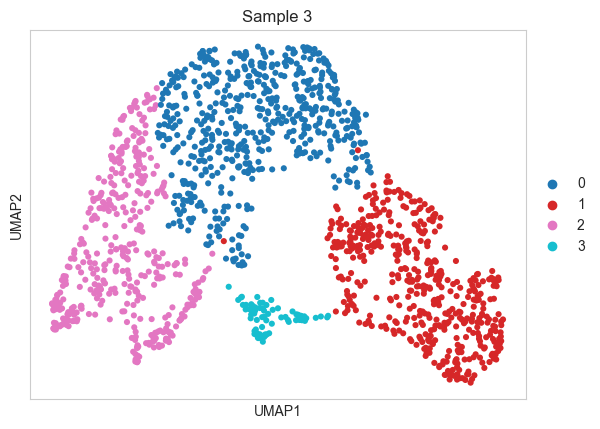

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

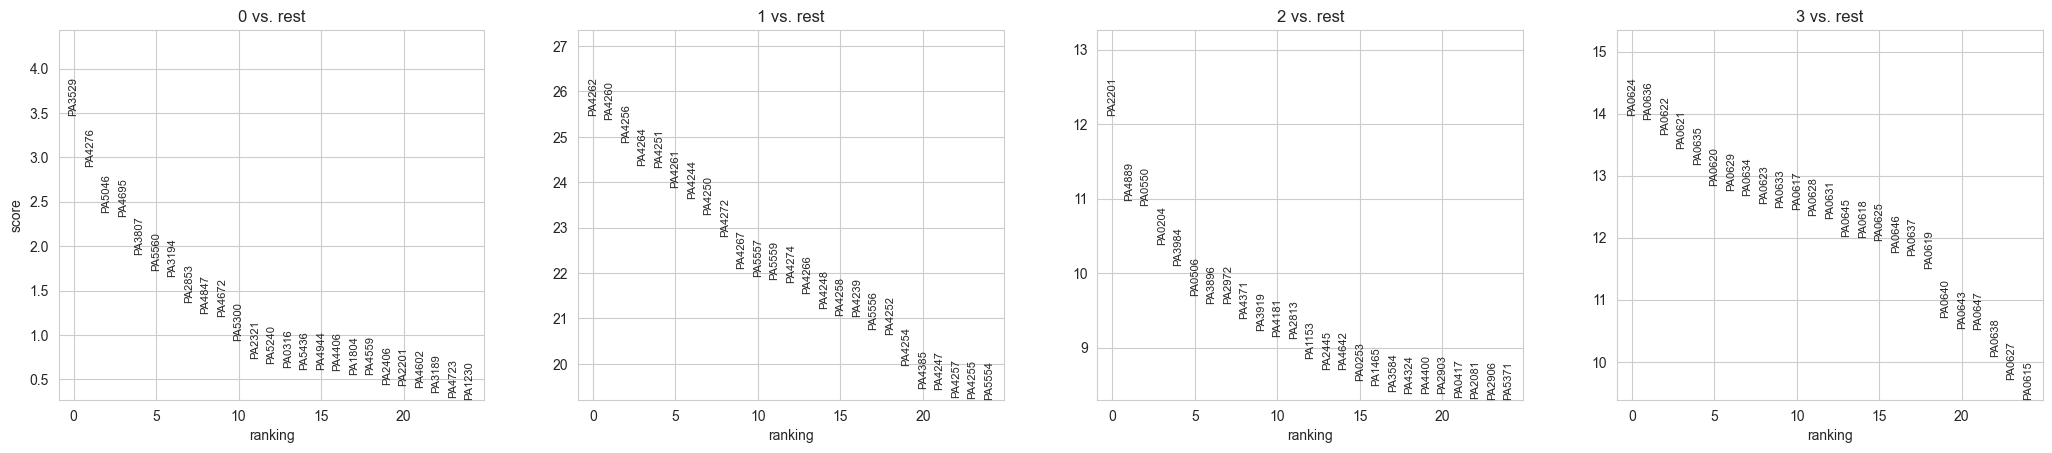

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

### Load and process null data

In [6]:
data_null_gen = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/null_data_opt_cor_scale_new.h5ad")

In [7]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

gene 0
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and Z

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


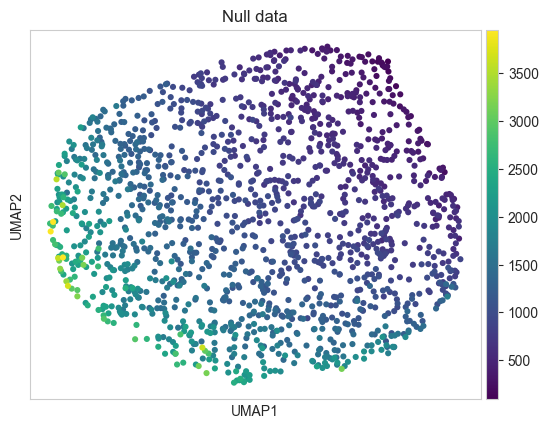

In [8]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="statsmod_auto")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["est_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [9]:
print(data_null_gen.var["gene_dist"].value_counts())
print(data_gene.var["gene_dist"].value_counts())


gene_dist
nb     4872
poi     681
Name: count, dtype: int64
gene_dist
nb     5144
poi     409
Name: count, dtype: int64


In [19]:
res2 = 0.105
sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
nclust = len(data_null_gen.obs["leiden"].unique())
print(nclust)

2


In [21]:
res2 = 0.01
twoclust = False

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
0.1
Resolution for two clusters: 0.105


In [22]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()


In [23]:
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.5780263912794034
Cluster 1 - DE genes: 84; Minimum q value: 0.0196078431372549
Cluster 2 - DE genes: 63; Minimum q value: 0.017241379310344827
Cluster 3 - DE genes: 0; Minimum q value: 0.15


In [24]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.05555555555555555
Cluster 1 - DE genes: 0; Minimum q value: 0.4
Cluster 2 - DE genes: 3294; Minimum q value: 0.012048192771084338
Cluster 3 - DE genes: 0; Minimum q value: 1.0


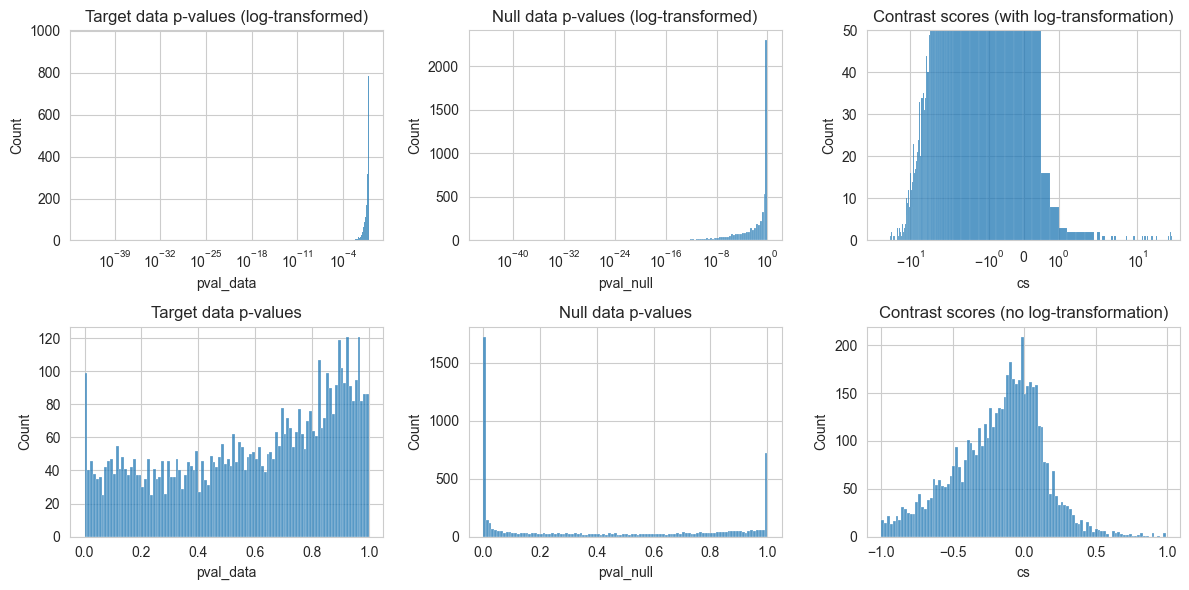

In [25]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

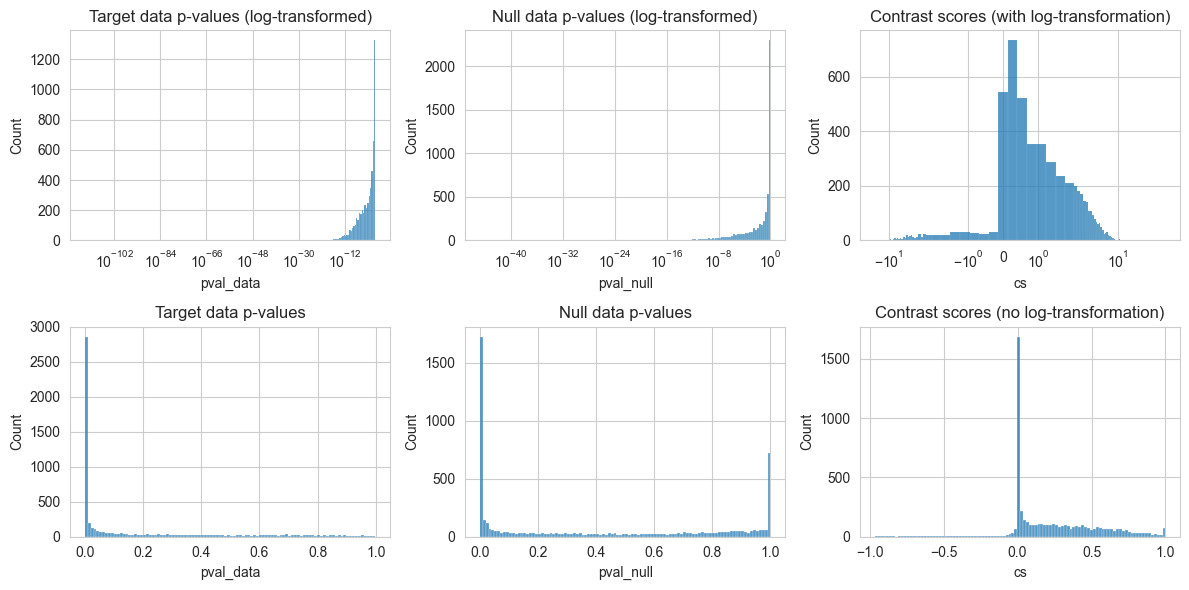

In [26]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [38]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA4244,1.382737e-19,4.837690e-03,18.859260,2.315362,16.543898,0.578026
PA1787,2.190582e-12,3.462649e-01,11.659441,0.460592,11.198849,0.578026
PA1800,4.061052e-10,8.684818e-01,9.391361,0.061239,9.330122,0.578026
PA0636,3.708294e-09,7.567112e-01,8.430826,0.121070,8.309756,0.578026
PA0631,4.372624e-09,5.293353e-01,8.359258,0.276269,8.082989,0.578026
...,...,...,...,...,...,...
PA4889,9.875432e-01,8.733738e-24,0.005444,23.058800,-23.053356,1.000000
PA1198,8.839087e-01,1.217346e-24,0.053593,23.914586,-23.860993,1.000000
PA5315,1.530448e-13,3.804040e-38,12.815181,37.419755,-24.604574,1.000000


In [28]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA0624,2.354790e-44,8.927218e-01,43.628048,0.049284,43.578764,0.15
PA0636,6.161842e-44,7.567112e-01,43.210289,0.121070,43.089220,0.15
PA0622,1.946223e-42,3.098013e-01,41.710807,0.508917,41.201891,0.15
PA0621,4.073517e-41,6.625289e-01,40.390030,0.178795,40.211235,0.15
PA0635,1.254658e-39,4.697964e-01,38.901475,0.328090,38.573384,0.15
...,...,...,...,...,...,...
PA1198,2.284686e-01,1.217346e-24,0.641174,23.914586,-23.273412,1.00
PA4262,4.799592e-01,1.437376e-25,0.318796,24.842430,-24.523634,1.00
PA0550,4.457813e-02,3.406195e-27,1.350878,26.467731,-25.116852,1.00


SignificanceResult(statistic=0.9999999856159425, pvalue=0.0)
[[1.        0.6429233]
 [0.6429233 1.       ]]


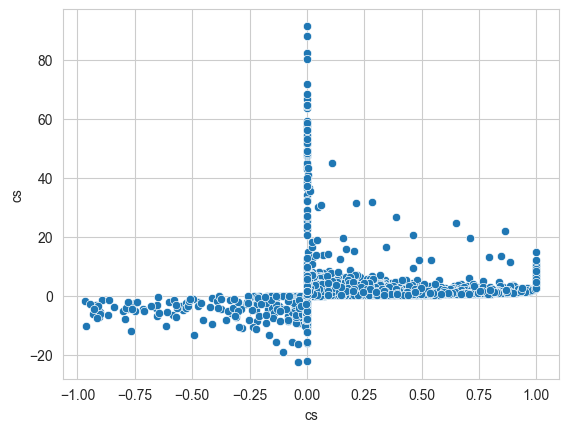

In [40]:
sns.scatterplot(x = pvals_gen["2"]["cs"], y = pvals_log_gen["2"]["cs"])

from scipy.stats import spearmanr
print(spearmanr(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))
print(np.corrcoef(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))


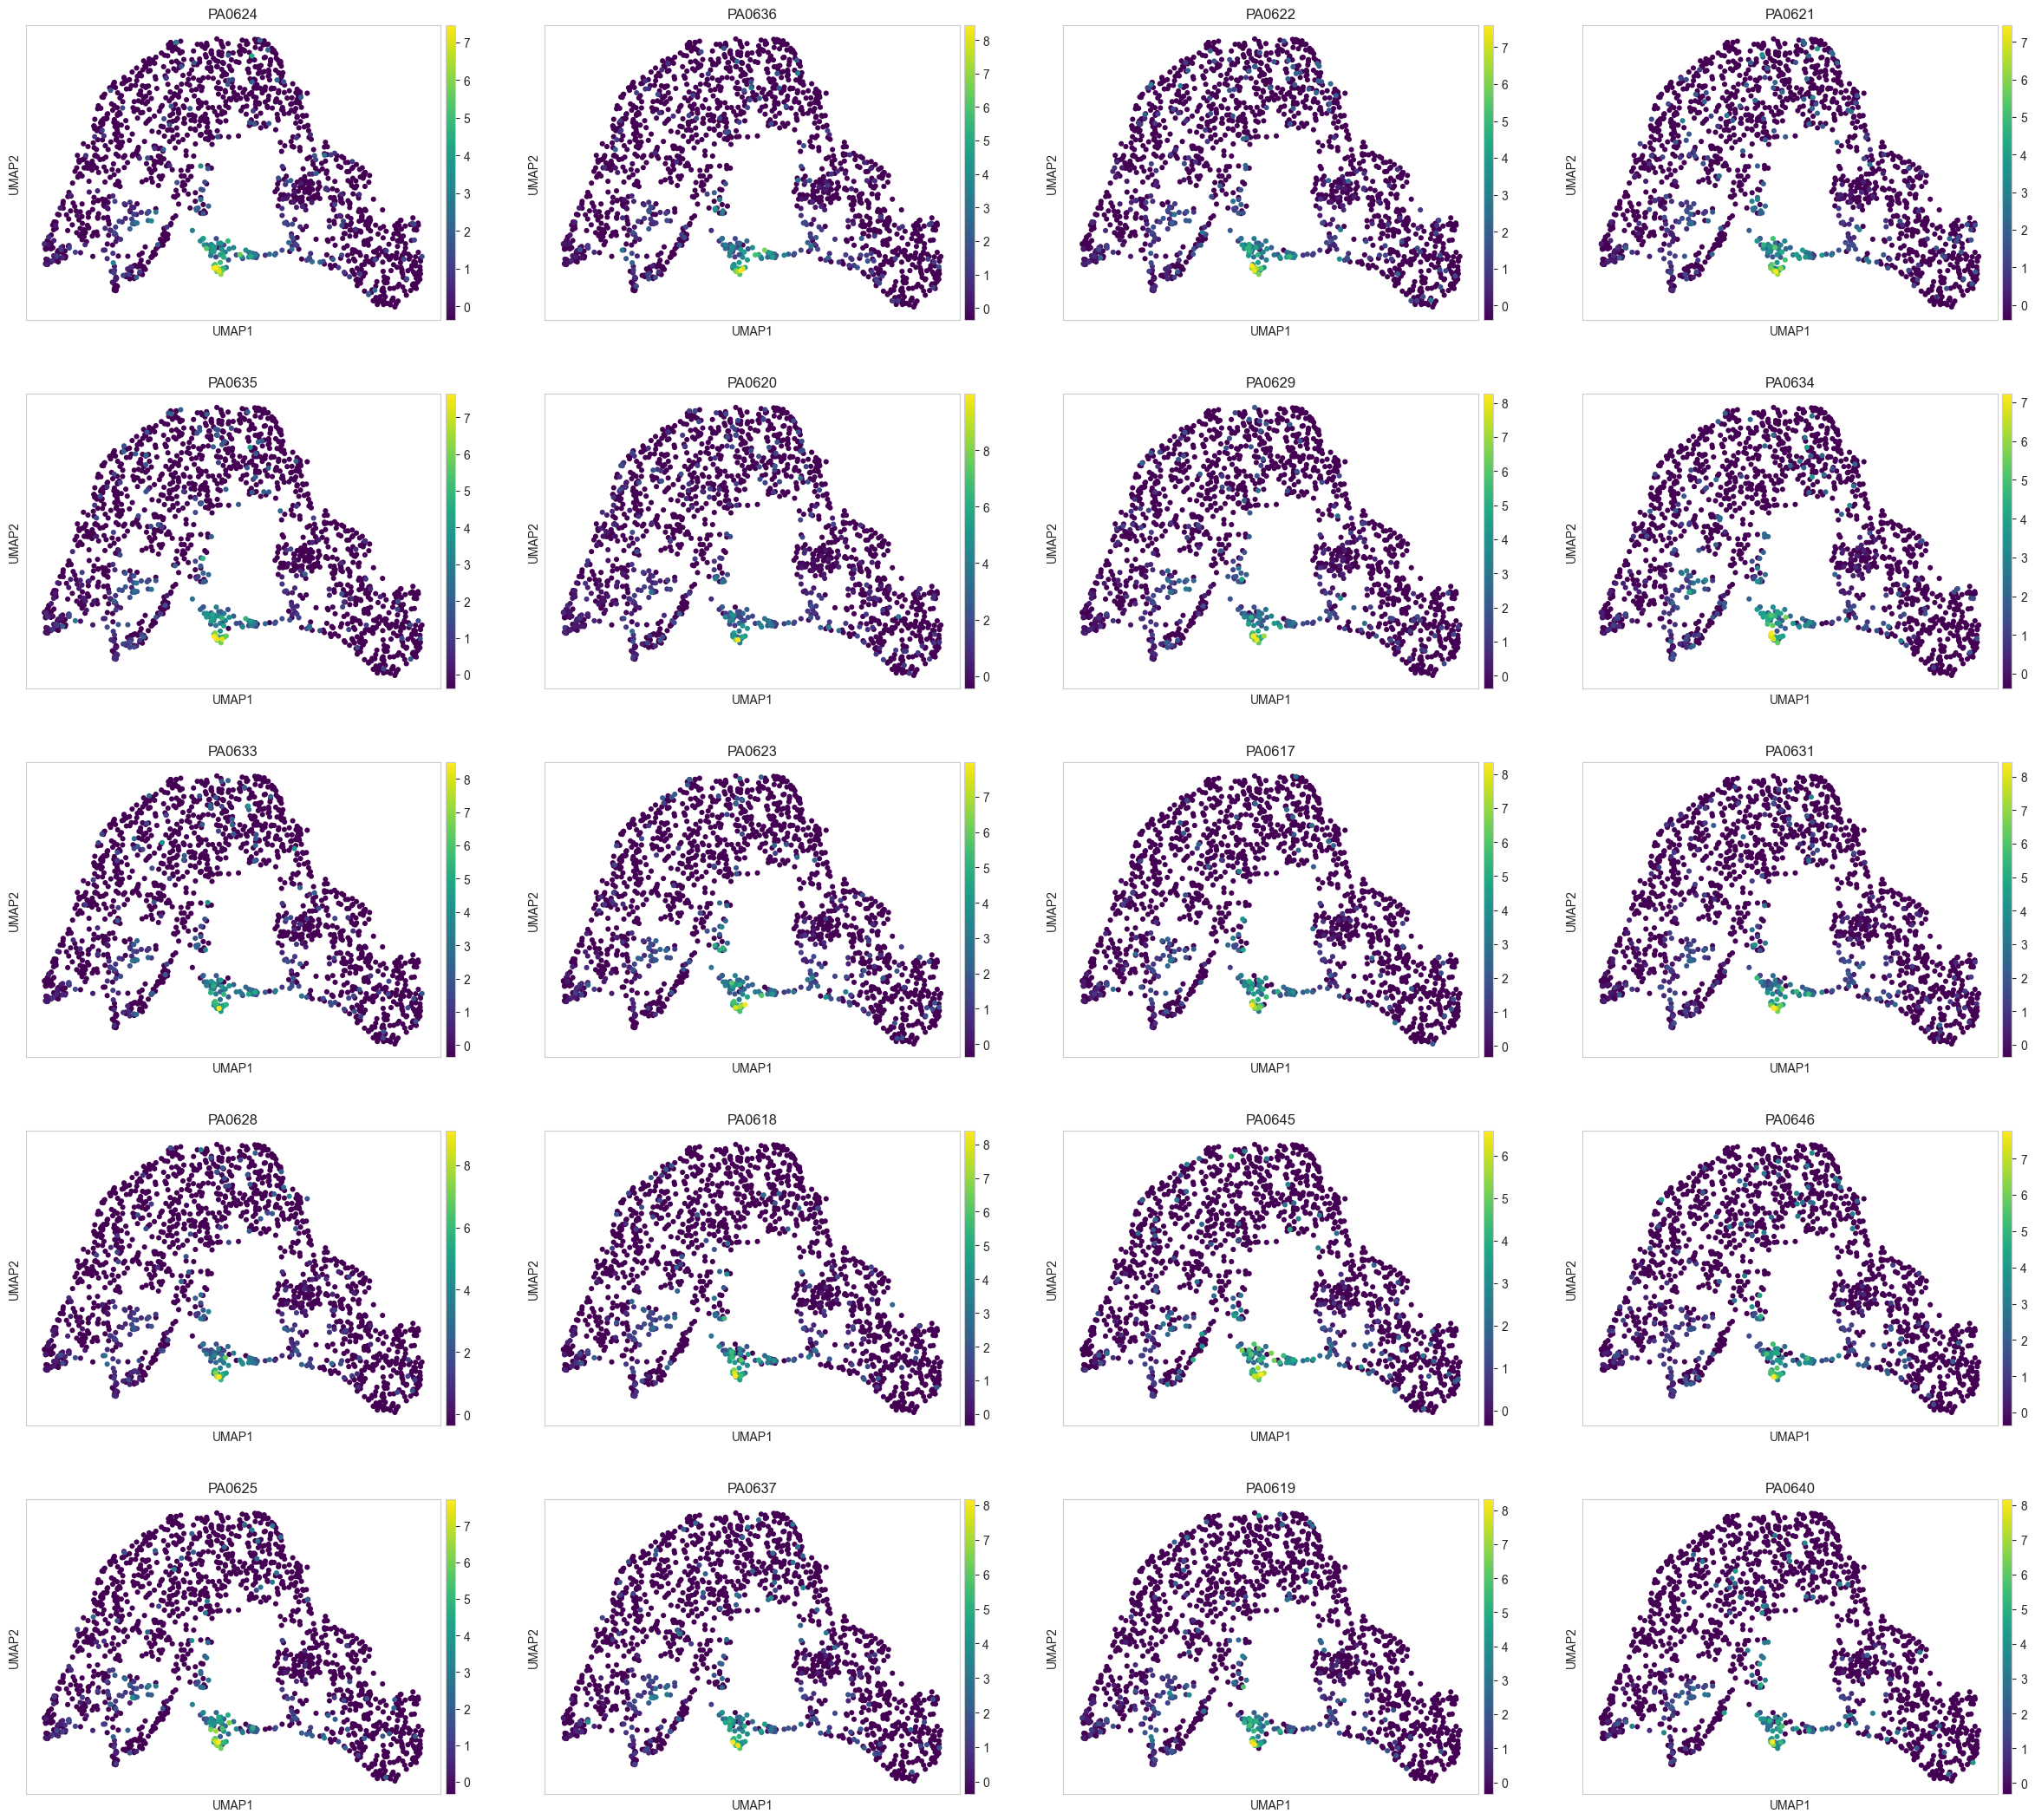

In [41]:
sc.pl.umap(data_gene, color=pvals_log_gen["3"].sort_values("q", ascending=True).index.tolist()[:20], cmap="viridis")


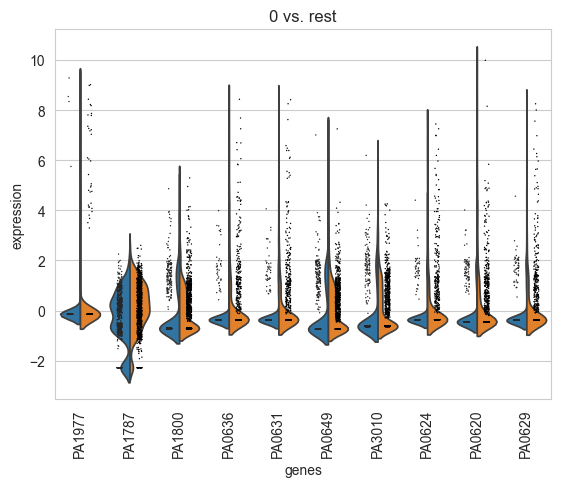

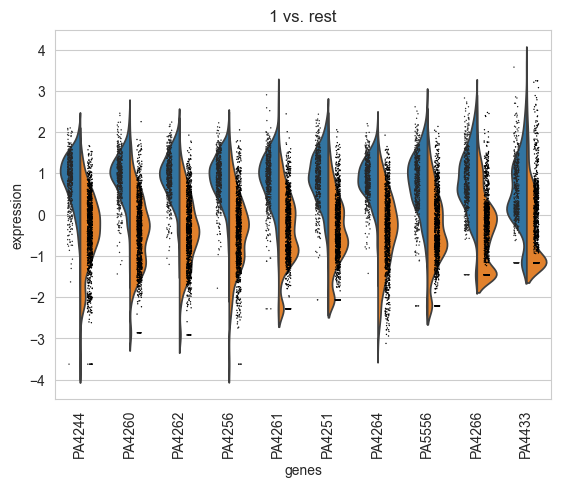

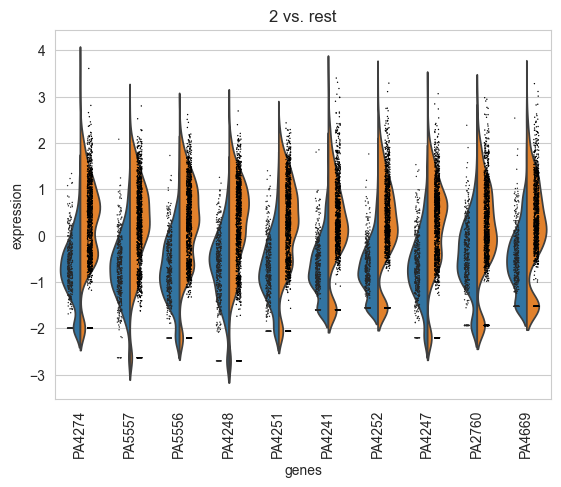

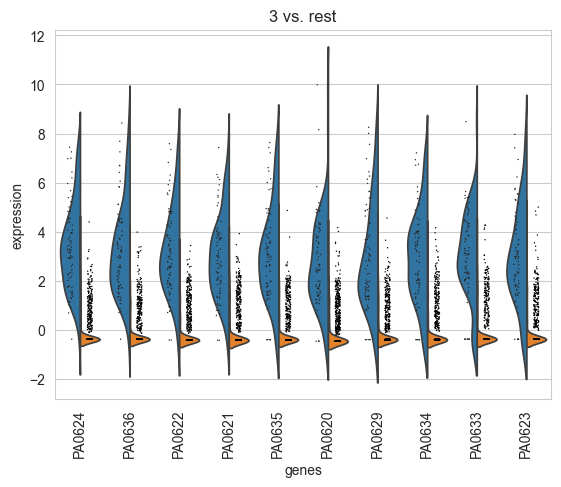

In [31]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), gene_names=pvals_log_gen[str(i)].sort_values("q", ascending=True).index.tolist()[:10])

In [32]:
pvals_log_gen["3"].to_csv("pvals_3.csv")